<a href="https://colab.research.google.com/github/skaria76/intro-ml-course-winter2025/blob/main/HAD7001_Course_Project_Filtered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Dataset

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("drive/My Drive/Primary Care_filtered_data2.csv")

Mounted at /content/drive


<ipython-input-1-3d9f78bb7e82>:4: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("drive/My Drive/Primary Care_filtered_data2.csv")


#Import Libraries/Packages

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Data Exploration and Cleaning

In [3]:
df.shape

(102736, 51)

In [4]:
# List the columns of the dataframe
print(df.columns.tolist())

['Age_at_Exam', 'Sex', 'sBP', 'sBP_Date', 'BMI', 'BMI_Date', 'LDL', 'LDL_Date', 'HDL', 'HDL_Date', 'A1c', 'A1c_Date', 'TG', 'TG_Date', 'FBS', 'FBS_Date', 'Total_Cholesterol', 'Total_Cholesterol_Lab_Date', 'Diabetes', 'HTN', 'HTN_OnsetDate', 'COPD', 'COPD_Date', 'Patient_ID', 'DM_OnsetDate', 'DM_Onset_Revised_1YrPrior', '[Amputation)', '[Arrhythmia)', '[AtrialFibrillation)', '[CABG)', '[CAD)', '[Cancer)', '[Cardiomyopathy)', '[CKD)', '[Deceased)', '[Deceased_Date]', '[Dialysis)', '[ESRD)', '[MyocardialInfarct)', '[NAFLD)', '[Nephropathy)', '[Neuropathy)', '[PeritonealDialysis)', '[Proteinuria)', '[PVD)', '[Sarcoma)', '[Stent)', '[Stroke)', '[Stroke_Date]', '[TIA)', 'Year']


In [5]:
# Get frequency of values, including missing (NaN) values
stroke_counts = df['[Stroke)'].value_counts(dropna=False)

# Print frequency counts
print(stroke_counts)


[Stroke)
0.0    97140
1.0     5596
Name: count, dtype: int64


In [6]:
# Get unique values
unique_values = df['[Stroke)'].unique()

# Print result
unique_values

array([0., 1.])

In [7]:
# Find columns with missing values
missing_values = df.isnull().sum()

# Filter columns that have missing values
missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print(missing_values)

sBP                               39
LDL                              416
HDL                              731
HDL_Date                         596
A1c                            49956
A1c_Date                       49721
TG                               702
TG_Date                          553
Total_Cholesterol               1780
Total_Cholesterol_Lab_Date      1633
HTN_OnsetDate                  40021
COPD_Date                      93023
DM_OnsetDate                   71439
DM_Onset_Revised_1YrPrior      72248
[Deceased_Date]               102736
[Stroke_Date]                  97140
dtype: int64


In [8]:
# Display missing values in a readable format
missing_values_df = pd.DataFrame({'Feature': df.columns, 'Missing Values': df.isnull().sum()})
print(missing_values_df)

                                               Feature  Missing Values
Age_at_Exam                                Age_at_Exam               0
Sex                                                Sex               0
sBP                                                sBP              39
sBP_Date                                      sBP_Date               0
BMI                                                BMI               0
BMI_Date                                      BMI_Date               0
LDL                                                LDL             416
LDL_Date                                      LDL_Date               0
HDL                                                HDL             731
HDL_Date                                      HDL_Date             596
A1c                                                A1c           49956
A1c_Date                                      A1c_Date           49721
TG                                                  TG             702
TG_Dat

In [9]:
pd.set_option('display.max_columns', None) #remove limit on max # of columns displayed

In [10]:
df.shape

(102736, 51)

In [11]:
# Count occurrences of each unique patient ID
patient_counts = df['Patient_ID'].value_counts()

# Filter patients that appear more than once
duplicate_patients = patient_counts[patient_counts > 1]

# Display the number of patients who appear more than once
print(f"Number of patients represented more than once: {len(duplicate_patients)}")

# Optionally, display the actual counts for each duplicated patient
print(duplicate_patients)

Number of patients represented more than once: 13389
Patient_ID
8001000807063728    153
4001000000011545    147
8001000805024400    138
8001000805024174    131
8001000805029756    121
                   ... 
7001000702003382      2
2001000000028387      2
1003000000071849      2
7001000701017692      2
1003000000067587      2
Name: count, Length: 13389, dtype: int64


In [12]:
df.head()

,Age_at_Exam,Sex,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,A1c_Date,TG,TG_Date,FBS,FBS_Date,Total_Cholesterol,Total_Cholesterol_Lab_Date,Diabetes,HTN,HTN_OnsetDate,COPD,COPD_Date,Patient_ID,DM_OnsetDate,DM_Onset_Revised_1YrPrior,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Deceased_Date],[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[Stroke_Date],[TIA),Year
0,43,Female,129.0,2010-12-13,20.000000,2011-02-02,2.02,2011-02-02,2.08,2011-02-02,NaN,NaN,0.69,2011-02-02,4.9,2011-02-02,4.42,2011-02-02,0,0,NaN,0,NaN,4001000000255907,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2010
1,69,Female,140.0,2015-03-10,28.000000,2015-04-08,4.04,2015-03-16,2.38,2015-03-16,NaN,NaN,1.58,2015-03-16,4.9,2015-03-16,7.14,2015-03-16,0,0,NaN,0,NaN,4001000000256036,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2015
2,56,Female,110.0,2013-11-05,65.317051,2013-11-05,3.04,2013-11-13,1.39,2013-11-13,NaN,NaN,1.04,2013-11-13,4.2,2013-11-13,4.90,2013-11-13,0,1,2013-06-25,0,NaN,4001000000256926,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,2013
3,65,Male,159.0,2014-03-21,23.000000,2014-03-21,5.07,2014-06-09,2.00,2014-06-09,NaN,NaN,0.92,2014-06-09,6.3,2014-06-09,7.49,2014-06-09,0,1,2015-03-20,0,NaN,4001000000255844,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2014
4,78,Female,120.0,2015-03-20,40.975293,2015-06-30,1.39,2015-02-25,0.87,2015-02-25,5.2,2015-02-25,1.22,2015-02-25,5.2,2015-02-25,2.81,2015-02-25,0,1,2009-09-10,1,2014-08-28,4001000000256057,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2015


In [13]:
description = df.describe()
description

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,FBS,Total_Cholesterol,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Deceased_Date],[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA),Year
count,102736.000000,102697.000000,102736.000000,102320.000000,102005.000000,52780.000000,102034.000000,102736.000000,100956.000000,102736.000000,102736.000000,102736.000000,1.027360e+05,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.0,0.0,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.0,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000,102736.000000
mean,63.371788,129.209967,29.345404,2.733291,1.394754,6.227432,1.472864,5.765893,4.784180,0.304635,0.610448,0.094543,3.366895e+15,0.016411,0.008536,0.057409,0.017180,0.077373,0.371934,0.007855,0.003699,0.0,NaN,0.001334,0.000837,0.094222,0.000857,0.003251,0.046780,0.0,0.011165,0.035839,0.003241,0.035674,0.054470,0.025755,2011.018621
std,13.760294,17.106422,6.636445,0.959721,0.416662,0.875836,0.940858,1.377827,1.147693,0.460255,0.487651,0.292585,1.947554e+15,0.127051,0.091998,0.232624,0.129942,0.267184,0.483323,0.088281,0.060705,0.0,NaN,0.036493,0.028921,0.292139,0.029255,0.056926,0.211169,0.0,0.105071,0.185891,0.056841,0.185477,0.226943,0.158405,2.373802
min,18.000000,40.000000,10.200000,0.100000,0.130000,3.100000,0.100000,2.000000,1.610000,0.000000,0.000000,0.000000,1.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2003.000000
25%,54.000000,119.000000,25.028664,2.020000,1.100000,5.700000,0.910000,5.000000,3.950000,0.000000,0.000000,0.000000,2.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000
50%,64.000000,129.000000,28.300000,2.650000,1.330000,6.000000,1.270000,5.400000,4.720000,0.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
75%,74.000000,140.000000,32.364783,3.360000,1.620000,6.600000,1.790000,6.100000,5.540000,1.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
max,90.000000,241.000000,218.700000,10.000000,4.720000,15.300000,57.340000,33.800000,20.820000,1.000000,1.000000,1.000000,9.001000e+15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000


# Age

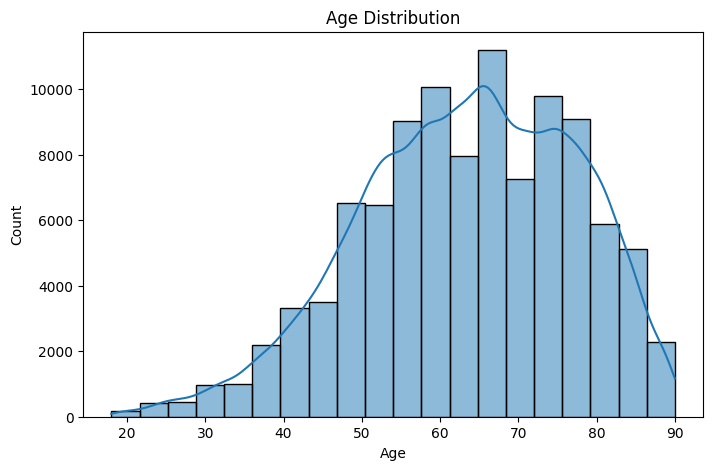

In [14]:
# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(df['Age_at_Exam'], bins=20, kde=True)  # kde=True adds a density curve
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

In [15]:
df.shape

(102736, 51)

# Systolic Blood Pressure

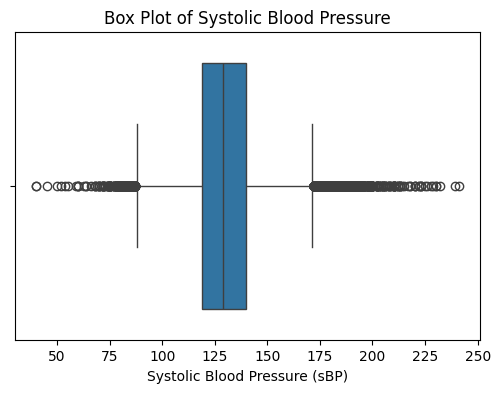

In [16]:
# Systolic Blood Pressure Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['sBP'])
plt.xlabel('Systolic Blood Pressure (sBP)')
plt.title('Box Plot of Systolic Blood Pressure')
plt.show()

In [17]:
# Count the number of records where sBP is < 90 or > 220
sbp_outlier_count = ((df['sBP'] < 90) | (df['sBP'] > 220)).sum()

# Print the count
print(f"Number of records with sBP below 90 or above 220: {sbp_outlier_count}")

Number of records with sBP below 90 or above 220: 412


In [18]:
# Define the feasible range for sBP (systolic blood pressure)
sbp_feasible_min = 90  # Lower bound
sbp_feasible_max = 220  # Upper bound

# Keep rows where sBP is within range OR is missing (NaN)
df = df[((df['sBP'] >= sbp_feasible_min) & (df['sBP'] <= sbp_feasible_max)) | df['sBP'].isna()]

In [19]:
df.describe()

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,FBS,Total_Cholesterol,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Deceased_Date],[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA),Year
count,102324.000000,102285.000000,102324.000000,101909.000000,101599.000000,52575.000000,101625.000000,102324.000000,100551.000000,102324.000000,102324.000000,102324.000000,1.023240e+05,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.0,0.0,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.0,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000,102324.000000
mean,63.374506,129.379929,29.358059,2.734824,1.394746,6.227266,1.473877,5.766566,4.786148,0.304709,0.611372,0.094318,3.367477e+15,0.016350,0.008473,0.057191,0.017112,0.077196,0.371731,0.007721,0.003714,0.0,NaN,0.001339,0.000840,0.094064,0.000850,0.003245,0.046714,0.0,0.011102,0.035769,0.003235,0.035671,0.054357,0.025732,2011.017308
std,13.752390,16.840055,6.635213,0.959540,0.416589,0.876013,0.941847,1.377896,1.147486,0.460286,0.487441,0.292272,1.948366e+15,0.126818,0.091659,0.232208,0.129691,0.266903,0.483269,0.087527,0.060827,0.0,NaN,0.036566,0.028979,0.291919,0.029147,0.056869,0.211027,0.0,0.104780,0.185714,0.056784,0.185469,0.226721,0.158335,2.374820
min,18.000000,90.000000,10.200000,0.100000,0.130000,3.100000,0.100000,2.000000,1.610000,0.000000,0.000000,0.000000,1.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2003.000000
25%,54.000000,119.000000,25.050000,2.020000,1.100000,5.700000,0.910000,5.000000,3.950000,0.000000,0.000000,0.000000,2.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000
50%,64.000000,129.000000,28.300000,2.660000,1.330000,6.000000,1.270000,5.400000,4.720000,0.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
75%,74.000000,140.000000,32.380000,3.370000,1.620000,6.600000,1.790000,6.100000,5.540000,1.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
max,90.000000,220.000000,218.700000,10.000000,4.720000,15.300000,57.340000,33.800000,20.820000,1.000000,1.000000,1.000000,9.001000e+15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000


In [20]:
df.shape

(102324, 51)

In [21]:
# Find columns with missing values
missing_values = df.isnull().sum()

# Filter columns that have missing values
missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print(missing_values)

sBP                               39
LDL                              415
HDL                              725
HDL_Date                         590
A1c                            49749
A1c_Date                       49514
TG                               699
TG_Date                          550
Total_Cholesterol               1773
Total_Cholesterol_Lab_Date      1626
HTN_OnsetDate                  39766
COPD_Date                      92673
DM_OnsetDate                   71145
DM_Onset_Revised_1YrPrior      71952
[Deceased_Date]               102324
[Stroke_Date]                  96762
dtype: int64


# Body Mass Index (BMI)

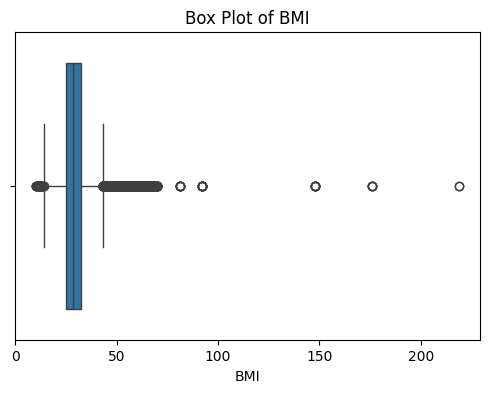

In [22]:
# BMI Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['BMI'])
plt.xlabel('BMI')
plt.title('Box Plot of BMI')
plt.show()


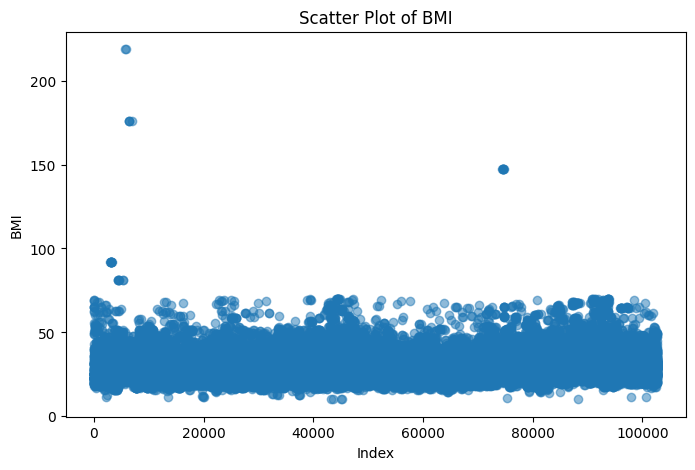

In [23]:
plt.figure(figsize=(8, 5))
plt.scatter(df.index, df['BMI'], alpha=0.5)
plt.xlabel('Index')
plt.ylabel('BMI')
plt.title('Scatter Plot of BMI')
plt.show()

In [24]:
# Count values where BMI is greater than 50
bmi_above_50_count = (df['BMI'] > 50).sum()

# Print the count
print(f"Number of BMI values above 50: {bmi_above_50_count}")

Number of BMI values above 50: 1188


In [25]:
# Count values where BMI is greater than 50
bmi_below_15_count = (df['BMI'] < 15).sum()

# Print the count
print(f"Number of BMI values below 15: {bmi_below_15_count}")

Number of BMI values below 15: 35


In [26]:
# Keep only rows where BMI is between 15 and 50
df = df[(df['BMI'] >= 15) & (df['BMI'] <= 50)]

In [27]:
df.shape

(101101, 51)

# LDL Cholesterol

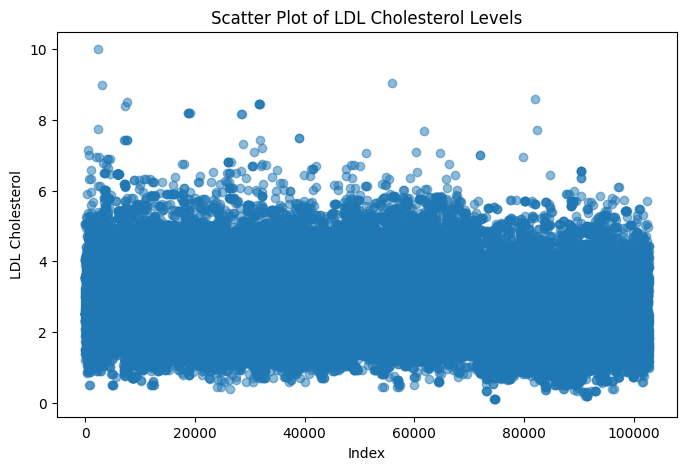

In [28]:
# Scatter plot of LDL values
plt.figure(figsize=(8, 5))
plt.scatter(df.index, df['LDL'], alpha=0.5)
plt.xlabel('Index')
plt.ylabel('LDL Cholesterol')
plt.title('Scatter Plot of LDL Cholesterol Levels')
plt.show()


In [29]:
# Define the feasible range for LDL (Low-Density Lipoprotein Cholesterol)
ldl_feasible_min = 0.5  # Lower bound
ldl_feasible_max = 10.0  # Upper bound

# Keep rows where LDL is within range OR is missing (NaN)
df = df[((df['LDL'] >= ldl_feasible_min) & (df['LDL'] <= ldl_feasible_max)) | df['LDL'].isna()]

In [30]:
df.shape

(101059, 51)

# HDL Cholesterol

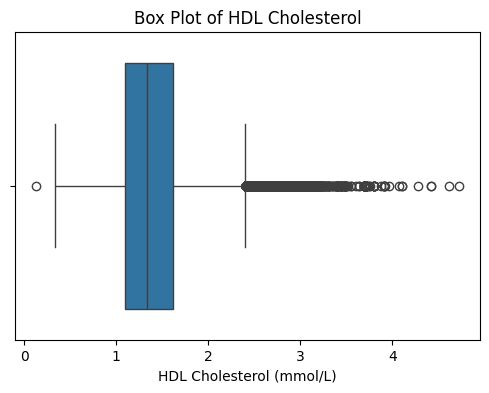

In [31]:
# Create the HDL box plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['HDL'])
plt.xlabel('HDL Cholesterol (mmol/L)')
plt.title('Box Plot of HDL Cholesterol')
plt.show()

In [32]:
# Define the feasible range for HDL cholesterol
hdl_feasible_min = 0.5  # Lower bound
hdl_feasible_max = 3.5  # Upper bound

# Keep rows where HDL is within range OR is missing (NaN)
df = df[((df['HDL'] >= hdl_feasible_min) & (df['HDL'] <= hdl_feasible_max)) | df['HDL'].isna()]

In [33]:
df.shape

(100939, 51)

In [34]:
df.describe()

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,FBS,Total_Cholesterol,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Deceased_Date],[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA),Year
count,100939.000000,100900.000000,100939.000000,100531.000000,100218.000000,51733.000000,100253.000000,100939.000000,99187.000000,100939.000000,100939.000000,100939.000000,1.009390e+05,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.0,0.0,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.0,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000,100939.000000
mean,63.437452,129.362398,29.016569,2.738953,1.395651,6.225984,1.472309,5.762168,4.790769,0.302083,0.610121,0.094205,3.372459e+15,0.016485,0.008579,0.057351,0.017278,0.077641,0.372839,0.007747,0.003586,0.0,NaN,0.001337,0.000852,0.094096,0.000862,0.003041,0.046840,0.0,0.010927,0.035546,0.003279,0.035576,0.054786,0.025788,2011.012770
std,13.741026,16.842777,5.638784,0.958904,0.412883,0.875743,0.943224,1.374962,1.146324,0.459164,0.487725,0.292116,1.947921e+15,0.127333,0.092228,0.232514,0.130305,0.267607,0.483562,0.087677,0.059779,0.0,NaN,0.036547,0.029177,0.291964,0.029346,0.055066,0.211297,0.0,0.103962,0.185157,0.057171,0.185231,0.227562,0.158503,2.375478
min,18.000000,90.000000,15.010000,0.500000,0.500000,3.100000,0.100000,2.000000,1.610000,0.000000,0.000000,0.000000,1.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2003.000000
25%,54.000000,119.000000,25.000000,2.020000,1.100000,5.700000,0.910000,5.000000,3.960000,0.000000,0.000000,0.000000,2.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000
50%,64.000000,129.000000,28.220000,2.660000,1.330000,6.000000,1.270000,5.400000,4.730000,0.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
75%,74.000000,140.000000,32.180000,3.370000,1.620000,6.600000,1.790000,6.100000,5.550000,1.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
max,90.000000,220.000000,50.000000,10.000000,3.500000,15.300000,57.340000,33.800000,20.820000,1.000000,1.000000,1.000000,9.001000e+15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000


# Hemoglobin A1C

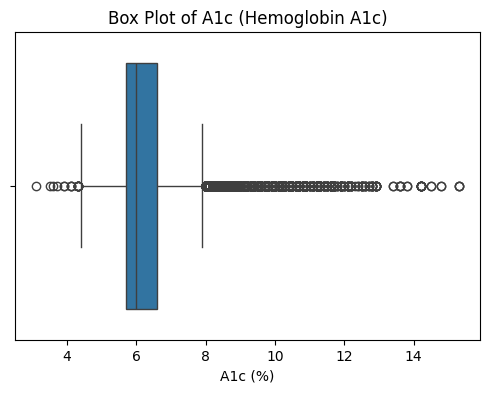

In [35]:
# Create the box plot for A1c
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['A1c'])
plt.xlabel('A1c (%)')
plt.title('Box Plot of A1c (Hemoglobin A1c)')
plt.show()

In [36]:
# Count A1c values outside the feasible range (below 3.5% or above 15%)
a1c_outlier_count = ((df['A1c'] < 3.5) | (df['A1c'] > 15)).sum()

# Print the result
print(f"Number of A1c values below 3.5% or above 15%: {a1c_outlier_count}")


Number of A1c values below 3.5% or above 15%: 4


In [37]:
# A1c left alone

In [38]:
df.shape

(100939, 51)

# Triglycerides

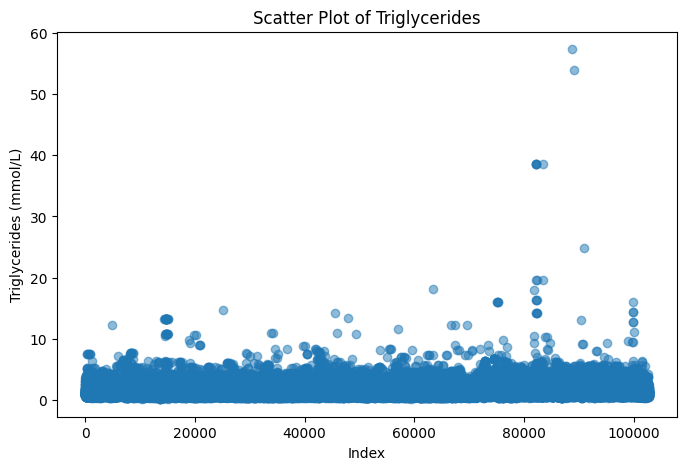

In [39]:
# Scatter plot of TG values
plt.figure(figsize=(8, 5))
plt.scatter(df.index, df['TG'], alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Triglycerides (mmol/L)')
plt.title('Scatter Plot of Triglycerides')
plt.show()


In [40]:
# Count TG values greater than 15 mmol/L
tg_above_15_count = (df['TG'] > 15).sum()

# Print the count
print(f"Number of triglyceride (TG) values above 15 mmol/L: {tg_above_15_count}")

Number of triglyceride (TG) values above 15 mmol/L: 21


In [41]:
# Define the feasible range for Triglycerides (TG)
feasible_min_tg = 0.3  # Lower bound
feasible_max_tg = 15.0  # Upper bound

# Keep rows where TG is within range OR is missing (NaN)
df = df[((df['TG'] >= feasible_min_tg) & (df['TG'] <= feasible_max_tg)) | df['TG'].isna()]

In [42]:
df.shape

(100877, 51)

In [43]:
df.describe()

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,FBS,Total_Cholesterol,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Deceased_Date],[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA),Year
count,100877.000000,100838.000000,100877.000000,100473.000000,100156.000000,51707.000000,100191.000000,100877.000000,99127.000000,100877.000000,100877.000000,100877.000000,1.008770e+05,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.0,0.0,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.0,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000,100877.000000
mean,63.440378,129.364436,29.017734,2.739236,1.395577,6.225179,1.467605,5.760734,4.789906,0.302051,0.610179,0.094253,3.372222e+15,0.016495,0.008585,0.057377,0.017288,0.077669,0.372801,0.007752,0.003589,0.0,NaN,0.001338,0.000853,0.094144,0.000862,0.003043,0.046839,0.0,0.010934,0.035538,0.003281,0.035598,0.054809,0.025794,2011.013472
std,13.740875,16.843181,5.638823,0.958979,0.412755,0.873508,0.851160,1.368785,1.142693,0.459150,0.487712,0.292182,1.947908e+15,0.127371,0.092256,0.232562,0.130344,0.267651,0.483552,0.087704,0.059797,0.0,NaN,0.036558,0.029186,0.292031,0.029355,0.055082,0.211295,0.0,0.103994,0.185137,0.057188,0.185286,0.227609,0.158520,2.375382
min,18.000000,90.000000,15.010000,0.500000,0.500000,3.100000,0.300000,2.000000,1.610000,0.000000,0.000000,0.000000,1.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2003.000000
25%,54.000000,119.000000,25.000000,2.020000,1.100000,5.700000,0.910000,5.000000,3.960000,0.000000,0.000000,0.000000,2.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000
50%,64.000000,129.000000,28.220000,2.660000,1.330000,6.000000,1.270000,5.400000,4.730000,0.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
75%,74.000000,140.000000,32.180000,3.370000,1.620000,6.600000,1.790000,6.100000,5.550000,1.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
max,90.000000,220.000000,50.000000,10.000000,3.500000,15.300000,14.760000,33.800000,13.620000,1.000000,1.000000,1.000000,9.001000e+15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000


# Fasting Blood Sugar (FBS)

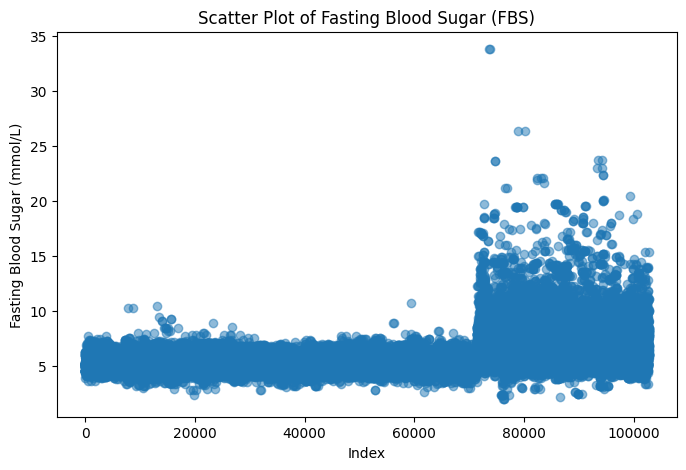

In [44]:
# Scatter plot of FBS values
plt.figure(figsize=(8, 5))
plt.scatter(df.index, df['FBS'], alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Fasting Blood Sugar (mmol/L)')
plt.title('Scatter Plot of Fasting Blood Sugar (FBS)')
plt.show()


In [45]:
# Count records where FBS is below 3.0 mmol/L
fbs_below_3_count = (df['FBS'] < 3.0).sum()

# Print the result
print(f"Number of observations with FBS below 3.0 mmol/L: {fbs_below_3_count}")

# Count records where FBS is above 25.0 mmol/L
fbs_above_25_count = (df['FBS'] > 25.0).sum()

# Print the result
print(f"Number of observations with FBS above 25.0 mmol/L: {fbs_above_25_count}")


Number of observations with FBS below 3.0 mmol/L: 37
Number of observations with FBS above 25.0 mmol/L: 4


In [46]:
# Define the feasible range for Fasting Blood Sugar (FBS)
feasible_min_fbs = 3.0  # Lower bound (hypoglycemia threshold)
feasible_max_fbs = 25.0  # Upper bound (severe hyperglycemia)

# Keep rows where FBS is within range OR is missing (NaN)
df = df[((df['FBS'] >= feasible_min_fbs) & (df['FBS'] <= feasible_max_fbs)) | df['FBS'].isna()]


In [47]:
df.shape

(100836, 51)

In [48]:
df.describe()

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,FBS,Total_Cholesterol,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Deceased_Date],[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA),Year
count,100836.000000,100797.000000,100836.000000,100432.000000,100115.000000,51678.000000,100152.000000,100836.000000,99091.000000,100836.000000,100836.000000,100836.000000,1.008360e+05,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.0,0.0,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.0,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000
mean,63.439268,129.364803,29.018010,2.739408,1.395664,6.224781,1.467745,5.760935,4.790226,0.301886,0.610119,0.094242,3.372224e+15,0.016413,0.008588,0.057400,0.017295,0.077700,0.372893,0.007755,0.003590,0.0,NaN,0.001339,0.000853,0.094163,0.000863,0.003025,0.046858,0.0,0.010939,0.035553,0.003283,0.035563,0.054792,0.025804,2011.013507
std,13.741562,16.843210,5.639419,0.958924,0.412766,0.872909,0.851248,1.358882,1.142565,0.459078,0.487725,0.292167,1.948015e+15,0.127057,0.092274,0.232607,0.130370,0.267701,0.483576,0.087722,0.059809,0.0,NaN,0.036565,0.029192,0.292057,0.029361,0.054914,0.211336,0.0,0.104014,0.185173,0.057200,0.185198,0.227575,0.158552,2.375382
min,18.000000,90.000000,15.010000,0.500000,0.500000,3.100000,0.300000,3.000000,1.610000,0.000000,0.000000,0.000000,1.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2003.000000
25%,54.000000,119.000000,25.000000,2.020000,1.100000,5.700000,0.910000,5.000000,3.960000,0.000000,0.000000,0.000000,2.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000
50%,64.000000,129.000000,28.220000,2.660000,1.330000,6.000000,1.270000,5.400000,4.730000,0.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
75%,74.000000,140.000000,32.180000,3.370000,1.620000,6.600000,1.790000,6.100000,5.550000,1.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
max,90.000000,220.000000,50.000000,10.000000,3.500000,15.300000,14.760000,23.700000,13.620000,1.000000,1.000000,1.000000,9.001000e+15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000


# Dropping additional unnecessary columns

In [49]:
# List of columns to drop
columns_to_drop = ['sBP_Date', 'BMI_Date', 'LDL_Date', 'HDL_Date', 'A1c_Date', 'TG_Date', 'FBS_Date', 'Total_Cholesterol', 'Total_Cholesterol_Lab_Date', 'HTN_OnsetDate', 'COPD_Date', 'DM_OnsetDate', 'DM_Onset_Revised_1YrPrior', '[Deceased_Date]', 'Year', '[Stroke_Date]']

# Drop the columns
df = df.drop(columns=columns_to_drop)

In [50]:
df.shape

(100836, 35)

In [51]:
df.describe()

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,FBS,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA)
count,100836.000000,100797.000000,100836.000000,100432.000000,100115.000000,51678.000000,100152.000000,100836.000000,100836.000000,100836.000000,100836.000000,1.008360e+05,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.0,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.0,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000
mean,63.439268,129.364803,29.018010,2.739408,1.395664,6.224781,1.467745,5.760935,0.301886,0.610119,0.094242,3.372224e+15,0.016413,0.008588,0.057400,0.017295,0.077700,0.372893,0.007755,0.003590,0.0,0.001339,0.000853,0.094163,0.000863,0.003025,0.046858,0.0,0.010939,0.035553,0.003283,0.035563,0.054792,0.025804
std,13.741562,16.843210,5.639419,0.958924,0.412766,0.872909,0.851248,1.358882,0.459078,0.487725,0.292167,1.948015e+15,0.127057,0.092274,0.232607,0.130370,0.267701,0.483576,0.087722,0.059809,0.0,0.036565,0.029192,0.292057,0.029361,0.054914,0.211336,0.0,0.104014,0.185173,0.057200,0.185198,0.227575,0.158552
min,18.000000,90.000000,15.010000,0.500000,0.500000,3.100000,0.300000,3.000000,0.000000,0.000000,0.000000,1.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,119.000000,25.000000,2.020000,1.100000,5.700000,0.910000,5.000000,0.000000,0.000000,0.000000,2.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64.000000,129.000000,28.220000,2.660000,1.330000,6.000000,1.270000,5.400000,0.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.000000,140.000000,32.180000,3.370000,1.620000,6.600000,1.790000,6.100000,1.000000,1.000000,0.000000,4.001000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,220.000000,50.000000,10.000000,3.500000,15.300000,14.760000,23.700000,1.000000,1.000000,1.000000,9.001000e+15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# Find columns with missing values
missing_values = df.isnull().sum()

# Filter columns that have missing values
missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print(missing_values)

sBP       39
LDL      404
HDL      721
A1c    49158
TG       684
dtype: int64


In [53]:
# Display missing values in a readable format
missing_values_df = pd.DataFrame({'Feature': df.columns, 'Missing Values': df.isnull().sum()})
print(missing_values_df)

                                   Feature  Missing Values
Age_at_Exam                    Age_at_Exam               0
Sex                                    Sex               0
sBP                                    sBP              39
BMI                                    BMI               0
LDL                                    LDL             404
HDL                                    HDL             721
A1c                                    A1c           49158
TG                                      TG             684
FBS                                    FBS               0
Diabetes                          Diabetes               0
HTN                                    HTN               0
COPD                                  COPD               0
Patient_ID                      Patient_ID               0
[Amputation)                  [Amputation)               0
[Arrhythmia)                  [Arrhythmia)               0
[AtrialFibrillation)  [AtrialFibrillation)              

In [54]:
df

,Age_at_Exam,Sex,sBP,BMI,LDL,HDL,A1c,TG,FBS,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA)
0,43,Female,129.0,20.000000,2.02,2.08,NaN,0.69,4.9,0,0,0,4001000000255907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69,Female,140.0,28.000000,4.04,2.38,NaN,1.58,4.9,0,0,0,4001000000256036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,65,Male,159.0,23.000000,5.07,2.00,NaN,0.92,6.3,0,1,0,4001000000255844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78,Female,120.0,40.975293,1.39,0.87,5.2,1.22,5.2,0,1,1,4001000000256057,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,83,Female,134.0,25.000000,2.52,1.48,NaN,1.15,4.6,0,1,0,4001000000256098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102731,53,Female,123.0,30.850000,1.84,1.65,6.4,0.84,6.6,1,0,0,4001000000046730,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102732,55,Female,96.0,30.950000,2.36,1.87,6.3,0.83,8.1,1,0,0,4001000000046730,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102733,53,Female,115.0,27.990000,1.84,1.65,6.5,0.84,6.9,1,0,0,4001000000046730,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102734,64,Female,136.0,29.043200,4.43,1.78,5.9,0.85,6.0,1,0,0,4001000000045462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Get frequency of values, including missing (NaN) values
stroke_counts = df['[Stroke)'].value_counts(dropna=False)

# Print frequency counts
print(stroke_counts)

[Stroke)
0.0    95311
1.0     5525
Name: count, dtype: int64


# Sex

In [56]:
print(df['Sex'].unique())  # Check unique values

['Female' 'Male']


In [57]:
# Encoding sex to numerical: 1 = Male, 0 = Female
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})


In [58]:
df

,Age_at_Exam,Sex,sBP,BMI,LDL,HDL,A1c,TG,FBS,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA)
0,43,0,129.0,20.000000,2.02,2.08,NaN,0.69,4.9,0,0,0,4001000000255907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69,0,140.0,28.000000,4.04,2.38,NaN,1.58,4.9,0,0,0,4001000000256036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,65,1,159.0,23.000000,5.07,2.00,NaN,0.92,6.3,0,1,0,4001000000255844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78,0,120.0,40.975293,1.39,0.87,5.2,1.22,5.2,0,1,1,4001000000256057,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,83,0,134.0,25.000000,2.52,1.48,NaN,1.15,4.6,0,1,0,4001000000256098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102731,53,0,123.0,30.850000,1.84,1.65,6.4,0.84,6.6,1,0,0,4001000000046730,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102732,55,0,96.0,30.950000,2.36,1.87,6.3,0.83,8.1,1,0,0,4001000000046730,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102733,53,0,115.0,27.990000,1.84,1.65,6.5,0.84,6.9,1,0,0,4001000000046730,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102734,64,0,136.0,29.043200,4.43,1.78,5.9,0.85,6.0,1,0,0,4001000000045462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Handling Duplicates in Patient ID

In [59]:
# Count occurrences of each unique patient ID
patient_counts = df['Patient_ID'].value_counts()

# Filter patients that appear more than once
duplicate_patients = patient_counts[patient_counts > 1]

# Display the number of patients who appear more than once
print(f"Number of patients represented more than once: {len(duplicate_patients)}")

# Optionally, display the actual counts for each duplicated patient
print(duplicate_patients)

Number of patients represented more than once: 13257
Patient_ID
8001000807063728    153
4001000000011545    147
8001000805024400    138
8001000805024174    131
8001000805029756    121
                   ... 
2001000000055556      2
1003000000058252      2
7001000706011071      2
2001000000045589      2
5001000502022185      2
Name: count, Length: 13257, dtype: int64


In [60]:
# Count how many patients have exactly one record
patients_with_one_observation = (patient_counts == 1).sum()

# Print the result
print(f"Number of patients who appear only once: {patients_with_one_observation}")

Number of patients who appear only once: 3789


#Only keeping last observation

In [61]:
# For patients with multiple observations, only keep the last observation
df = df.drop_duplicates(subset=['Patient_ID'], keep='last')  # Keeps the last occurrence

In [62]:
df.shape

(17046, 35)

In [63]:
df.describe()

,Age_at_Exam,Sex,sBP,BMI,LDL,HDL,A1c,TG,FBS,Diabetes,HTN,COPD,Patient_ID,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA)
count,17046.000000,17046.000000,17034.000000,17046.000000,16982.000000,16863.000000,6956.000000,16887.000000,17046.000000,17046.000000,17046.000000,17046.000000,1.704600e+04,17046.000000,17046.00000,17046.000000,17046.000000,17046.000000,17046.000000,17046.000000,17046.000000,17046.0,17046.000000,17046.000000,17046.000000,17046.000000,17046.000000,17046.000000,17046.0,17046.000000,17046.000000,17046.000000,17046.000000,17046.000000,17046.000000
mean,58.228323,0.361903,126.117236,28.256316,2.869032,1.432006,6.016196,1.390369,5.444852,0.159979,0.414173,0.070046,3.254941e+15,0.012672,0.00704,0.036138,0.009914,0.050393,0.335211,0.006688,0.002405,0.0,0.000645,0.000176,0.062771,0.000528,0.002581,0.033439,0.0,0.008800,0.021471,0.003051,0.027866,0.036255,0.015253
std,15.042331,0.480565,16.482543,5.625060,0.928378,0.421453,0.837317,0.834664,1.127447,0.366597,0.492593,0.255232,1.909688e+15,0.111856,0.08361,0.186638,0.099079,0.218761,0.472078,0.081507,0.048986,0.0,0.025396,0.013266,0.242558,0.022972,0.050742,0.179785,0.0,0.093396,0.144954,0.055149,0.164593,0.186929,0.122561
min,18.000000,0.000000,90.000000,15.010000,0.500000,0.500000,3.100000,0.300000,3.000000,0.000000,0.000000,0.000000,1.001000e+15,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,115.000000,24.232057,2.200000,1.130000,5.500000,0.850000,4.800000,0.000000,0.000000,0.000000,1.003000e+15,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,58.000000,0.000000,125.000000,27.500000,2.820000,1.370000,5.800000,1.190000,5.200000,0.000000,0.000000,0.000000,4.001000e+15,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,69.000000,1.000000,136.000000,31.227500,3.470000,1.670000,6.300000,1.700000,5.700000,0.000000,1.000000,0.000000,4.001000e+15,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,1.000000,218.000000,50.000000,9.000000,3.480000,13.800000,14.760000,23.000000,1.000000,1.000000,1.000000,9.001000e+15,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
# Get frequency of values, including missing (NaN) values
stroke_counts = df['[Stroke)'].value_counts(dropna=False)

# Print frequency counts
print(stroke_counts)

[Stroke)
0.0    16428
1.0      618
Name: count, dtype: int64


In [65]:
# Count occurrences of each unique patient ID
patient_counts = df['Patient_ID'].value_counts()

# Filter patients that appear more than once
duplicate_patients = patient_counts[patient_counts > 1]

# Display the number of patients who appear more than once
print(f"Number of patients represented more than once: {len(duplicate_patients)}")

Number of patients represented more than once: 0


# SKIPPED - OPTION 2 for handling multiple patient observations: Aggregating to mode for binary features and mean for continous

In [66]:
"""def mode(x):
    # Calculate mode using Pandas and handle multiple modes by returning the first one
    modes = x.mode()
    if modes.empty:
        return np.nan
    else:
        return modes.iloc[0]

# Prepare the aggregation dictionary
aggregations = {
    'Age_at_Exam': 'mean',
    'Sex': mode,
    'sBP': 'mean',
    'BMI': 'mean',
    'LDL': 'mean',
    'HDL': 'mean',
    'A1c': 'mean',
    'TG': 'mean',
    'FBS': 'mean',
    'Diabetes': mode,
    'HTN': mode,
    'COPD': mode,
    '[Amputation)': mode,
    '[Arrhythmia)': mode,
    '[AtrialFibrillation)': mode,
    '[CABG)': mode,
    '[CAD)': mode,
    '[Cancer)': mode,
    '[Cardiomyopathy)': mode,
    '[CKD)': mode,
    '[Deceased)': mode,
    '[Dialysis)': mode,
    '[ESRD)': mode,
    '[MyocardialInfarct)': mode,
    '[NAFLD)': mode,
    '[Nephropathy)': mode,
    '[Neuropathy)': mode,
    '[PeritonealDialysis)': mode,
    '[Proteinuria)': mode,
    '[PVD)': mode,
    '[Sarcoma)': mode,
    '[Stent)': mode,
    '[Stroke)': mode,
    '[TIA)': mode
}
# Group by 'Patient_ID' and aggregate
df = df.groupby('Patient_ID').agg(aggregations).reset_index()

# Print the result
df"""

"def mode(x):\n    # Calculate mode using Pandas and handle multiple modes by returning the first one\n    modes = x.mode()\n    if modes.empty:\n        return np.nan\n    else:\n        return modes.iloc[0]\n\n# Prepare the aggregation dictionary\naggregations = {\n    'Age_at_Exam': 'mean',\n    'Sex': mode,\n    'sBP': 'mean',\n    'BMI': 'mean',\n    'LDL': 'mean',\n    'HDL': 'mean',\n    'A1c': 'mean',\n    'TG': 'mean',\n    'FBS': 'mean',\n    'Diabetes': mode,\n    'HTN': mode,\n    'COPD': mode,\n    '[Amputation)': mode,\n    '[Arrhythmia)': mode,\n    '[AtrialFibrillation)': mode,\n    '[CABG)': mode,\n    '[CAD)': mode,\n    '[Cancer)': mode,\n    '[Cardiomyopathy)': mode,\n    '[CKD)': mode,\n    '[Deceased)': mode,\n    '[Dialysis)': mode,\n    '[ESRD)': mode,\n    '[MyocardialInfarct)': mode,\n    '[NAFLD)': mode,\n    '[Nephropathy)': mode,\n    '[Neuropathy)': mode,\n    '[PeritonealDialysis)': mode,\n    '[Proteinuria)': mode,\n    '[PVD)': mode,\n    '[Sarcoma)': m

# Drop Patient ID column

In [67]:
# Drop the 'Patient_ID' column
df = df.drop(columns=['Patient_ID'])

In [68]:
df

,Age_at_Exam,Sex,sBP,BMI,LDL,HDL,A1c,TG,FBS,Diabetes,HTN,COPD,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA)
18,65,1,140.0,23.000000,5.07,2.00,NaN,0.92,6.3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,47,0,116.0,20.000000,1.76,1.75,NaN,0.77,4.7,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,50,0,122.0,29.733333,2.61,1.53,NaN,1.58,5.3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,60,1,125.0,23.357220,2.11,1.06,NaN,0.76,3.9,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,45,1,112.0,21.810132,3.26,1.28,NaN,1.24,4.5,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102726,59,0,110.0,25.060000,3.44,1.49,6.2,1.18,5.7,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102728,84,1,147.0,23.420000,1.34,1.28,7.3,1.41,11.1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102730,69,1,110.0,33.890000,1.51,0.63,7.2,1.45,8.2,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102733,53,0,115.0,27.990000,1.84,1.65,6.5,0.84,6.9,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Display missing values in a readable format
missing_values_df = pd.DataFrame({'Feature': df.columns, 'Missing Values': df.isnull().sum()})
print(missing_values_df)

                                   Feature  Missing Values
Age_at_Exam                    Age_at_Exam               0
Sex                                    Sex               0
sBP                                    sBP              12
BMI                                    BMI               0
LDL                                    LDL              64
HDL                                    HDL             183
A1c                                    A1c           10090
TG                                      TG             159
FBS                                    FBS               0
Diabetes                          Diabetes               0
HTN                                    HTN               0
COPD                                  COPD               0
[Amputation)                  [Amputation)               0
[Arrhythmia)                  [Arrhythmia)               0
[AtrialFibrillation)  [AtrialFibrillation)               0
[CABG)                              [CABG)              

# drop A1c due to high level of missingness

In [70]:
# Drop the 'A1c' column due to missingness
df = df.drop(columns=['A1c'])

In [71]:
df

,Age_at_Exam,Sex,sBP,BMI,LDL,HDL,TG,FBS,Diabetes,HTN,COPD,[Amputation),[Arrhythmia),[AtrialFibrillation),[CABG),[CAD),[Cancer),[Cardiomyopathy),[CKD),[Deceased),[Dialysis),[ESRD),[MyocardialInfarct),[NAFLD),[Nephropathy),[Neuropathy),[PeritonealDialysis),[Proteinuria),[PVD),[Sarcoma),[Stent),[Stroke),[TIA)
18,65,1,140.0,23.000000,5.07,2.00,0.92,6.3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,47,0,116.0,20.000000,1.76,1.75,0.77,4.7,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,50,0,122.0,29.733333,2.61,1.53,1.58,5.3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,60,1,125.0,23.357220,2.11,1.06,0.76,3.9,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,45,1,112.0,21.810132,3.26,1.28,1.24,4.5,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102726,59,0,110.0,25.060000,3.44,1.49,1.18,5.7,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102728,84,1,147.0,23.420000,1.34,1.28,1.41,11.1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102730,69,1,110.0,33.890000,1.51,0.63,1.45,8.2,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102733,53,0,115.0,27.990000,1.84,1.65,0.84,6.9,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Machine Learning Analysis

# Splitting into Test/Train

In [72]:
# Split the data into features and target variable
X = df.drop('[Stroke)', axis=1)
y = df['[Stroke)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the list of features to impute
features_to_impute = ['sBP', 'LDL', 'HDL', 'TG']

# Create an imputer that fills missing values with the mean
mean_imputer = SimpleImputer(strategy='mean')

# Apply imputation to selected features
X[features_to_impute] = mean_imputer.fit_transform(X[features_to_impute])

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test = scaler.transform(X_test)        # transform the test set

# Oversampling minority class

In [73]:
# Apply SMOTE to balance dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print(f"New class distribution:\n{y_resampled.value_counts()}")

New class distribution:
[Stroke)
0.0    16428
1.0    16428
Name: count, dtype: int64


# Re-checking missingness

In [74]:
# Display missing values in a readable format
missing_values_df = pd.DataFrame({'Feature': df.columns, 'Missing Values': df.isnull().sum()})
print(missing_values_df)

                                   Feature  Missing Values
Age_at_Exam                    Age_at_Exam               0
Sex                                    Sex               0
sBP                                    sBP              12
BMI                                    BMI               0
LDL                                    LDL              64
HDL                                    HDL             183
TG                                      TG             159
FBS                                    FBS               0
Diabetes                          Diabetes               0
HTN                                    HTN               0
COPD                                  COPD               0
[Amputation)                  [Amputation)               0
[Arrhythmia)                  [Arrhythmia)               0
[AtrialFibrillation)  [AtrialFibrillation)               0
[CABG)                              [CABG)               0
[CAD)                                [CAD)              

# Logistic Regression Model Training

In [75]:
# Define 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression model with balanced class weights
model = LogisticRegression(solver='liblinear', class_weight='balanced')

# Perform cross-validation
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='roc_auc')

# Print average AUC score across folds
print(f"Mean AUC-ROC Score: {np.mean(cv_scores):.4f}")

Mean AUC-ROC Score: 0.8181


In [76]:
# Split into train/test set (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Train logistic regression model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probability scores for AUC

# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      3286
         1.0       0.75      0.73      0.74      3286

    accuracy                           0.75      6572
   macro avg       0.75      0.75      0.75      6572
weighted avg       0.75      0.75      0.75      6572

AUC-ROC Score: 0.8150


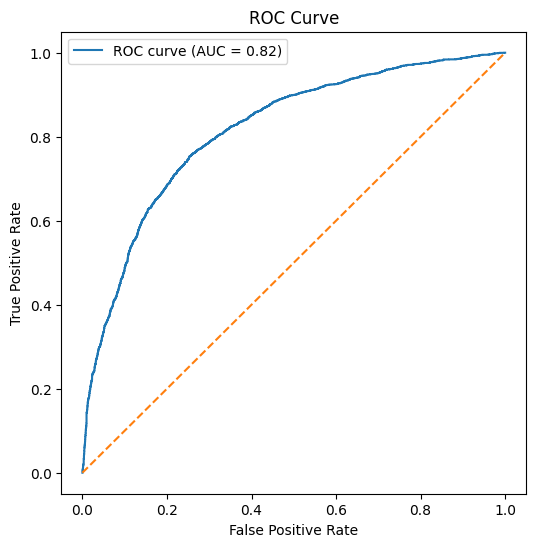

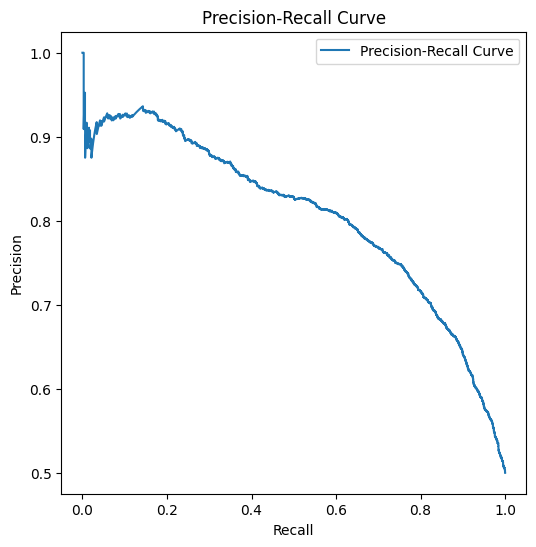

In [77]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


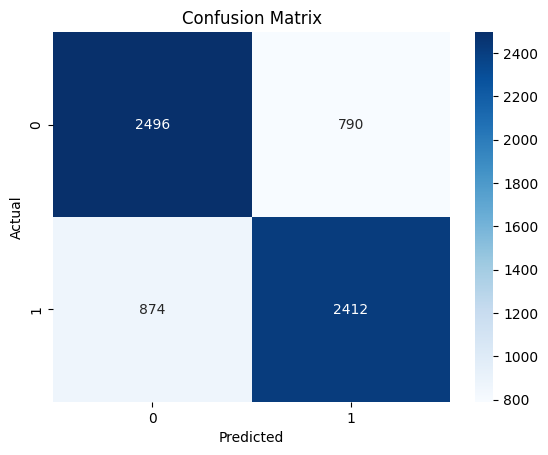

In [78]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [79]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve, roc_curve
)
# Get model predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probability scores for AUC

# Compute core performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print classification report
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))

# Print key metrics
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall (Sensitivity): {recall:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print(f"🔹 AUC-ROC Score: {roc_auc:.4f}")

🔹 Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      3286
         1.0       0.75      0.73      0.74      3286

    accuracy                           0.75      6572
   macro avg       0.75      0.75      0.75      6572
weighted avg       0.75      0.75      0.75      6572

🔹 Accuracy: 0.7468
🔹 Precision: 0.7533
🔹 Recall (Sensitivity): 0.7340
🔹 F1 Score: 0.7435
🔹 AUC-ROC Score: 0.8150


# Random Forest Classifier

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100}
Best F1 Score (CV): 0.1454367114816713
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.74      0.84      1643
         1.0       0.08      0.58      0.14        62

    accuracy                           0.74      1705
   macro avg       0.53      0.66      0.49      1705
weighted avg       0.95      0.74      0.82      1705

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.76      0.85      3286
         1.0       0.09      0.62      0.15       124

    accuracy                           0.75      3410
   macro avg       0.53      0.69      0.50      3410
weighted avg       0.95      0.75      0.83      3410



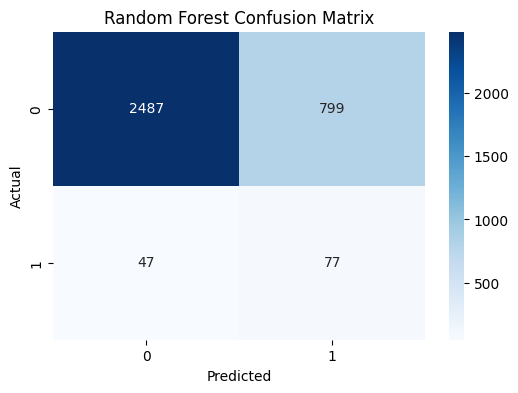

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42

# 1. Define x and y

X = df.drop('[Stroke)', axis=1)
y = df['[Stroke)']

# 2. Split (train+val, test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED
)

# 3. Further split (train, val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.125,  # 0.125 of 80% = 10% overall
    stratify=y_temp,
    random_state=RANDOM_SEED
)

# 4. Impute Missing Values
continuous_cols = ['Age_at_Exam', 'sBP', 'LDL', 'HDL', 'TG']
imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train[continuous_cols])
X_train[continuous_cols] = imputer.transform(X_train[continuous_cols])
X_val[continuous_cols] = imputer.transform(X_val[continuous_cols])
X_test[continuous_cols] = imputer.transform(X_test[continuous_cols])

# 5. Scale Continuous Variables
scaler = StandardScaler()

scaler.fit(X_train[continuous_cols])
X_train[continuous_cols] = scaler.transform(X_train[continuous_cols])
X_val[continuous_cols] = scaler.transform(X_val[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# 6. Model Training with Cross-Validation
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'class_weight': [None, 'balanced']
}

rf_model = RandomForestClassifier(random_state=RANDOM_SEED)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

# 7. Validate on the Validation Set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Final Evaluation on Test Set
y_test_pred = best_model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# XG Boost Classifier

In [82]:
# Cleaning column names to comply with XG Boost requirements
df = df.rename(columns=lambda x: x.replace('[', '(')
                                   .replace(']', ')')
                                   .replace('<', 'lt')
                                   .replace('>', 'gt'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 10}
Best CV F1 Score: 0.16842349317550004
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3286
         1.0       0.14      0.21      0.17       124

    accuracy                           0.92      3410
   macro avg       0.55      0.58      0.56      3410
weighted avg       0.94      0.92      0.93      3410



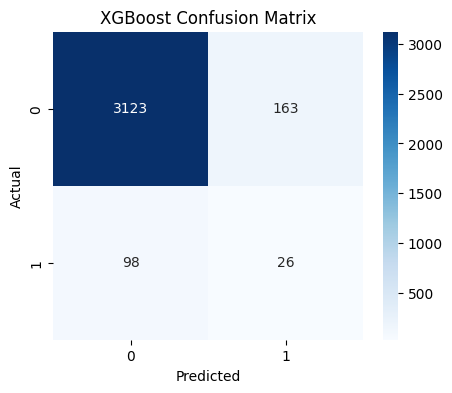

In [83]:
import numpy as np
import pandas as pd

# Preprocessing & Splits
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Model & Evaluation
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data

X = df.drop('(Stroke)', axis=1)
y = df['(Stroke)']

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 3. Impute missing values
continuous_cols = ['sBP', 'LDL', 'HDL', 'TG']
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train[continuous_cols])

X_train[continuous_cols] = imputer.transform(X_train[continuous_cols])
X_test[continuous_cols]  = imputer.transform(X_test[continuous_cols])

# 4. Scale continuous features
scaler = StandardScaler()
scaler.fit(X_train[continuous_cols])

X_train[continuous_cols] = scaler.transform(X_train[continuous_cols])
X_test[continuous_cols]  = scaler.transform(X_test[continuous_cols])

# 5. Define XGBoost model
xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Suppress XGBoost's default warning
)

# 6. Set up parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    # For imbalanced data, might try scale_pos_weight = #neg / #pos
    # But let's do a few discrete guesses to tune:
    'scale_pos_weight': [1, 10]
}

# 7. Cross-validation with GridSearch
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',  # or 'roc_auc', 'precision', etc.
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

# Pick the best model
best_xgb = grid_search.best_estimator_

# 8. Evaluate on Test Set
y_test_pred = best_xgb.predict(X_test)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)

# 9. Confusion Matrix Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()